In [1]:
import glob
import re

INPUT_FOLDER = '../../../travelogues-corpus/16th_century/books'

def read_file(f):
  with open(f, 'r') as file:
    str = file.read()
    ascii_only = re.sub('[^A-Za-z0-9 ]+', '', str)
    return re.sub('\\s+', ' ', ascii_only)

filenames = [f for f in glob.glob(INPUT_FOLDER + '**/*.txt')]
texts = [ read_file(f) for f in filenames ]

f'Loaded {len(texts)} documents'

'Loaded 66 documents'

In [2]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = stopwords.words('german')

extra_stopwords = []

with open('stopwords.txt') as f:
  extra_stopwords = f.readlines()
  extra_stopwords = [ x.strip() for x in extra_stopwords ]

stop_words.extend(extra_stopwords)
stop_words.sort()

[nltk_data] Downloading package stopwords to /home/simonr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import itertools
import matplotlib.pyplot as plt
import string

# We'll do stemming to avoid duplicate variants
porter = PorterStemmer()

def stem_message(text):
  words = word_tokenize(text)

  stemmed_words = []
  for word in words:
    stemmed_words.append(porter.stem(word))
    
  # Remove stopwords here
  clean_tokens = [w for w in stemmed_words if not w in stop_words and len(w) > 3] 
  return ' '.join(clean_tokens)

cleaned_texts = []
for text in texts:
  # Remove punctutation
  text = text.translate(str.maketrans('', '', string.punctuation))
  cleaned_texts.append(stem_message(text))

In [4]:
import string
import gensim

training_data = [ gensim.models.doc2vec.TaggedDocument(txt.split(), [ i ]) for i, txt in enumerate(cleaned_texts) ]

model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(training_data)
model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs)

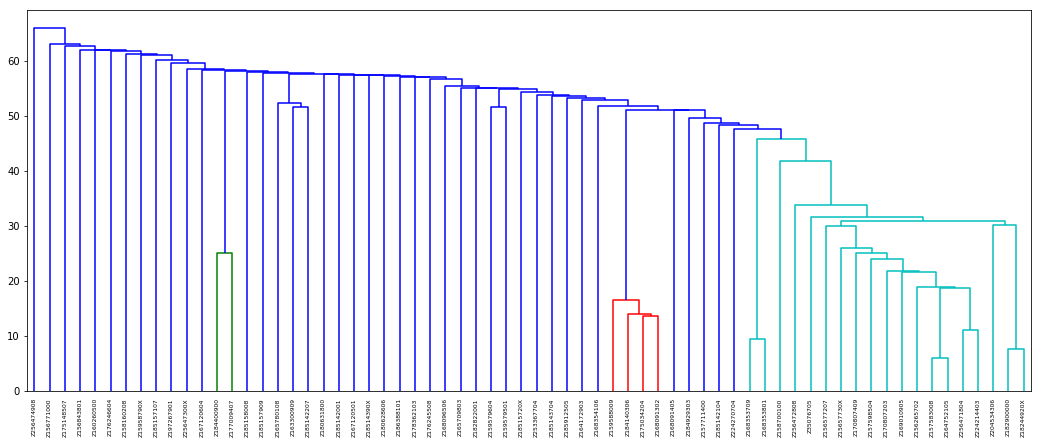

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

vectors = [ model.docvecs[idx] for idx in range(0, len(texts)) ]

linked = linkage(vectors, 'single')

def to_barcode(filename):
  return filename[filename.rindex('/') + 1: -4]

labelList = [ to_barcode(f) for f in filenames ]

plt.figure(figsize=(18, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()